<a href="https://colab.research.google.com/github/666888rwy-bit/phy77/blob/main/2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Mathematical Foundation for 2D Simulation

### 2D Time-Dependent Schrödinger Equation
The equation we are solving in 2D is:

$$
i\hbar \frac{\partial \psi}{\partial t} = \hat{H}\psi = \left[ -\frac{\hbar^2}{2m} \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) + V(x,y) \right] \psi(x,y,t)
$$

### 2D Split-Step Fourier Method
The SSFM extends naturally to 2D:

$$
\psi(x, y, t + \Delta t) \approx e^{-iV(x,y)\Delta t/2\hbar} \cdot \mathcal{F}^{-1}_2\left[ e^{-i\hbar (k_x^2 + k_y^2) \Delta t/2m} \cdot \mathcal{F}_2\left[ e^{-iV(x,y)\Delta t/2\hbar} \psi(x,y,t) \right] \right]
$$

Where:
- $\mathcal{F}_2$ and $\mathcal{F}^{-1}_2$ are 2D Fourier and inverse Fourier transforms
- $k_x$ and $k_y$ are the momentum space coordinates in x and y directions
- The kinetic energy term now depends on both $k_x^2$ and $k_y^2$

In [ ]:
# ============================================================================
# Import Libraries
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from scipy import fftpack
import warnings
warnings.filterwarnings('ignore')

# For displaying animations in the notebook
from IPython.display import HTML

## 2. Physical and Numerical Parameters Setup

We define the physical constants and numerical grid parameters for our 2D simulation:
- Spatial grid dimensions and resolution
- Time step for evolution
- Physical constants (using atomic units for simplicity)

In [ ]:
hbar = 1.0
m = 1.0
Nx, Ny = 128, 128  # Number of grid points (powers of 2 for FFT efficiency)
Lx, Ly = 10.0, 10.0  # Size of the spatial domains
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')
dx = x[1] - x[0]
dy = y[1] - y[0]
kx = 2 * np.pi * fftpack.fftfreq(Nx, d=dx)
ky = 2 * np.pi * fftpack.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
dt = 0.001
num_steps = 200

## 3. 2D Potential Function: Infinite Square Well

We create a 2D infinite square well potential:
- Zero potential inside the well region
- Very high potential outside to confine the wave function

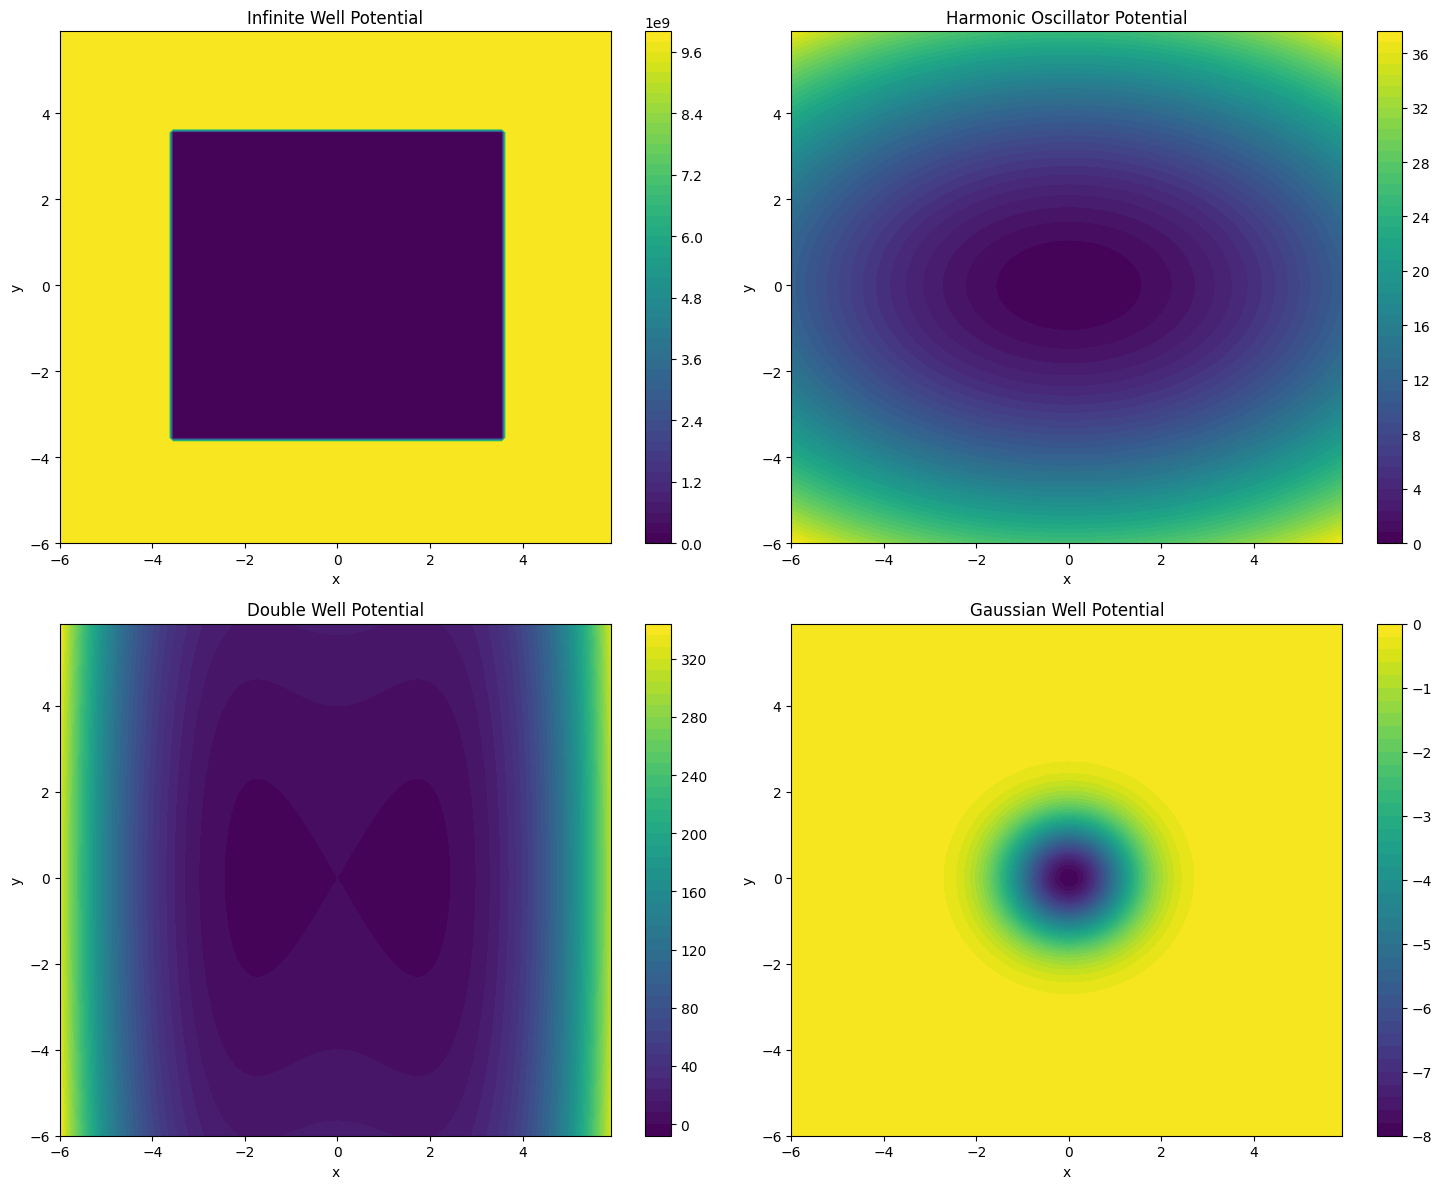

In [ ]:
# ============================================================================
# Enhanced Physical Parameters
# ============================================================================
hbar = 1.0
m = 1.0

# ============================================================================
# Enhanced 2D Numerical Parameters
# ============================================================================
# Spatial grid parameters
Nx, Ny = 128, 128
Lx, Ly = 12.0, 12.0

# Create enhanced 2D spatial grid
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')
dx = x[1] - x[0]
dy = y[1] - y[0]

# Enhanced 2D momentum grid
kx = 2 * np.pi * fftpack.fftfreq(Nx, d=dx)
ky = 2 * np.pi * fftpack.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='ij')

# Enhanced time parameters
dt = 0.0005  # Smaller time step for better accuracy
num_steps = 400  # More steps for longer simulation

# ============================================================================
# Multiple Potential Functions
# ============================================================================
def create_potential(potential_type, X, Y, params=None):
    """Create different types of 2D potentials"""
    if params is None:
        params = {}

    if potential_type == "infinite_well":
        well_width_x = params.get('well_width_x', Lx * 0.6)
        well_width_y = params.get('well_width_y', Ly * 0.6)
        V = np.zeros_like(X)
        well_mask = (np.abs(X) < well_width_x/2) & (np.abs(Y) < well_width_y/2)
        V[~well_mask] = params.get('wall_height', 1e10)
        return V

    elif potential_type == "harmonic_oscillator":
        omega_x = params.get('omega_x', 1.0)
        omega_y = params.get('omega_y', 1.0)
        return 0.5 * m * (omega_x**2 * X**2 + omega_y**2 * Y**2)

    elif potential_type == "double_well":
        a = params.get('a', 0.5)
        b = params.get('b', 4.0)
        return a * (X**4 - b * X**2) + 0.5 * Y**2

    elif potential_type == "gaussian_well":
        depth = params.get('depth', -10.0)
        width = params.get('width', 1.0)
        return depth * np.exp(-(X**2 + Y**2) / (2 * width**2))

    else:
        return np.zeros_like(X)

# Create multiple potentials for comparison
potentials = {
    "Infinite Well": create_potential("infinite_well", X, Y),
    "Harmonic Oscillator": create_potential("harmonic_oscillator", X, Y,
                                          {'omega_x': 0.8, 'omega_y': 1.2}),
    "Double Well": create_potential("double_well", X, Y, {'a': 0.3, 'b': 6.0}),
    "Gaussian Well": create_potential("gaussian_well", X, Y, {'depth': -8.0})
}

# Plot all potentials
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (name, potential) in enumerate(potentials.items()):
    im = axes[idx].contourf(X, Y, potential, levels=50, cmap='viridis')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('y')
    axes[idx].set_title(f'{name} Potential')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

## 4. Initial Wave Function: 2D Gaussian Wave Packet

We initialize a 2D Gaussian wave packet with:
- Specified initial position (x₀, y₀)
- Width parameters (σₓ, σ_y)  
- Initial momentum components (kₓ₀, k_y₀)
- Proper normalization to ensure total probability = 1

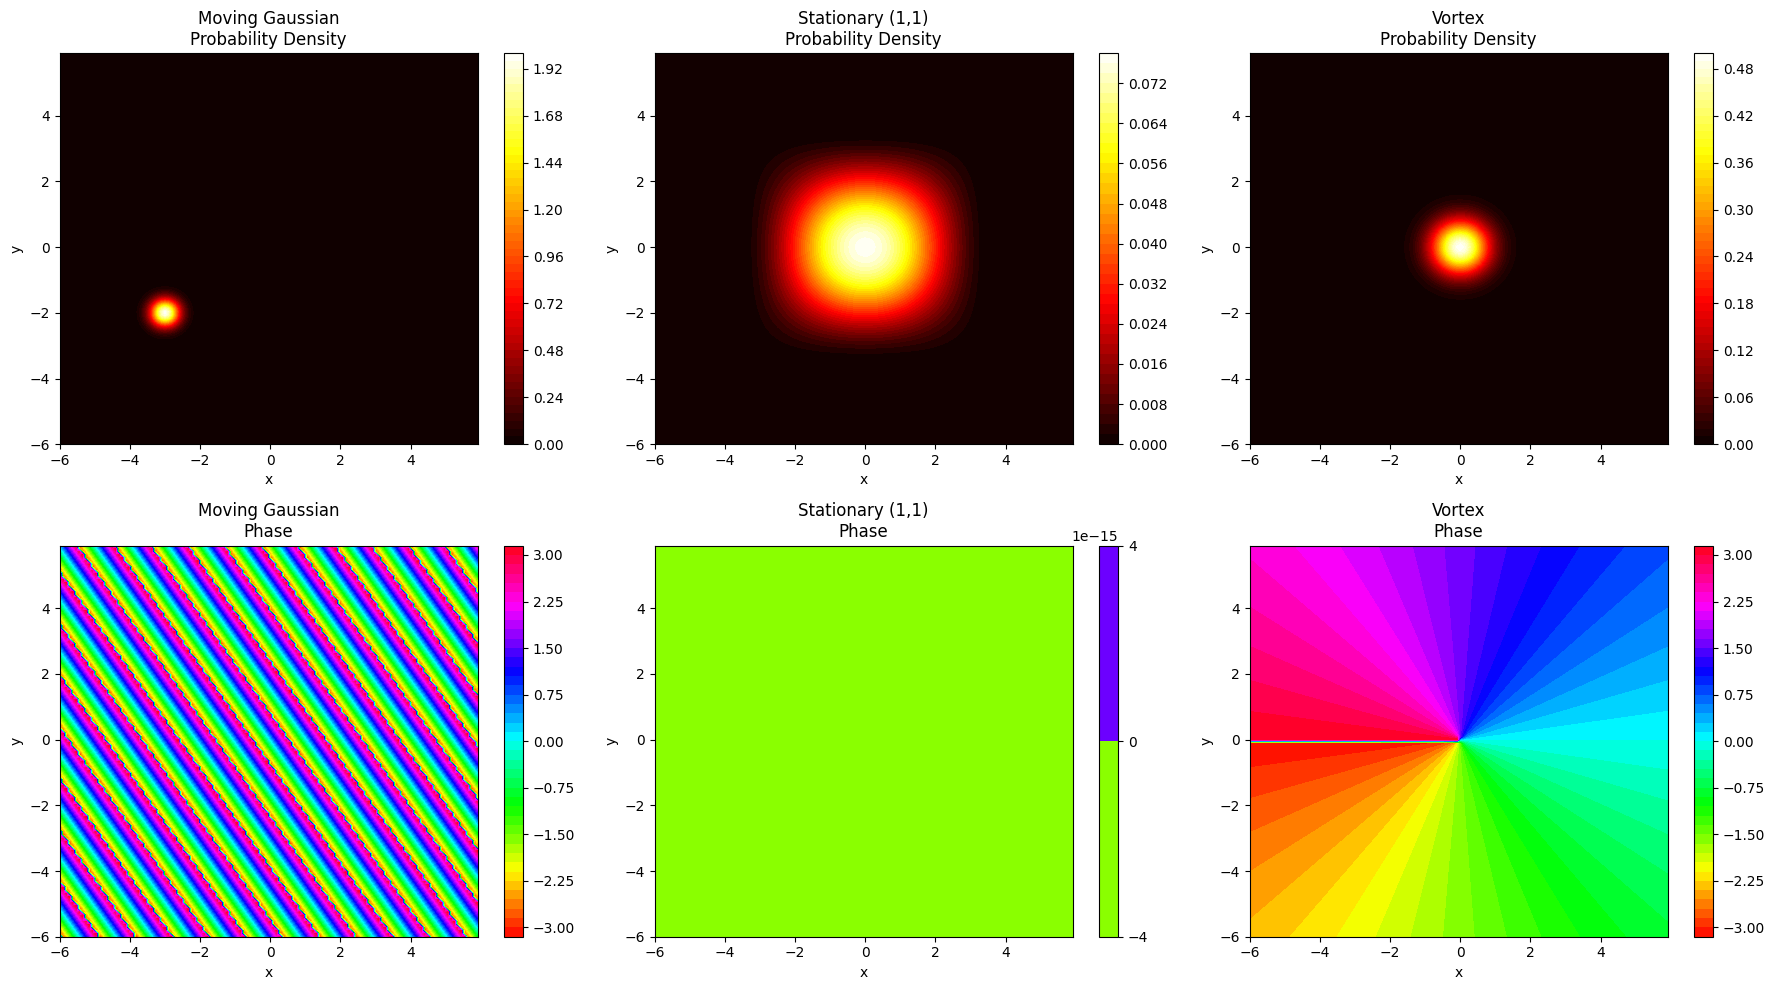

In [ ]:
# ============================================================================
# Multiple Initial Wave Functions
# ============================================================================
def create_initial_wavefunction(wave_type, X, Y, params=None):
    """Create different types of initial wave functions"""
    if params is None:
        params = {}

    if wave_type == "gaussian":
        x0 = params.get('x0', -2.0)
        y0 = params.get('y0', -2.0)
        sigma_x = params.get('sigma_x', 0.4)
        sigma_y = params.get('sigma_y', 0.4)
        kx0 = params.get('kx0', 5.0)
        ky0 = params.get('ky0', 5.0)

        psi = (np.exp(-(X - x0)**2 / (2 * sigma_x**2) -
                      (Y - y0)**2 / (2 * sigma_y**2)) *
               np.exp(1j * (kx0 * X + ky0 * Y)))

    elif wave_type == "stationary":
        # Stationary state in infinite well
        n_x = params.get('n_x', 1)
        n_y = params.get('n_y', 1)
        well_width_x = params.get('well_width_x', Lx * 0.6)
        well_width_y = params.get('well_width_y', Ly * 0.6)

        # Create wavefunction that's zero outside well
        psi = np.zeros_like(X, dtype=np.complex128)
        well_mask = (np.abs(X) < well_width_x/2) & (np.abs(Y) < well_width_y/2)

        # Inside well: stationary state
        x_well = X[well_mask]
        y_well = Y[well_mask]
        psi_well = (np.sin(n_x * np.pi * (x_well + well_width_x/2) / well_width_x) *
                    np.sin(n_y * np.pi * (y_well + well_width_y/2) / well_width_y))
        psi[well_mask] = psi_well

    elif wave_type == "vortex":
        # Wavefunction with vortex (phase singularity)
        x0 = params.get('x0', 0.0)
        y0 = params.get('y0', 0.0)
        sigma = params.get('sigma', 1.0)
        charge = params.get('charge', 1)  # Vortex charge

        r = np.sqrt((X - x0)**2 + (Y - y0)**2)
        theta = np.arctan2(Y - y0, X - x0)

        psi = np.exp(-r**2 / (2 * sigma**2)) * np.exp(1j * charge * theta)

    else:
        # Default Gaussian
        psi = np.exp(-(X**2 + Y**2) / 0.5)

    # Normalize
    norm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    return psi / norm

# Create multiple initial conditions
initial_wavefunctions = {
    "Moving Gaussian": create_initial_wavefunction("gaussian", X, Y,
                                                 {'x0': -3.0, 'y0': -2.0,
                                                  'kx0': 6.0, 'ky0': 4.0}),
    "Stationary (1,1)": create_initial_wavefunction("stationary", X, Y,
                                                  {'n_x': 1, 'n_y': 1}),
    "Vortex": create_initial_wavefunction("vortex", X, Y,
                                        {'charge': 1, 'sigma': 0.8})
}

# Plot initial wavefunctions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for idx, (name, psi) in enumerate(initial_wavefunctions.items()):
    # Probability density
    im1 = axes[0, idx].contourf(X, Y, np.abs(psi)**2, levels=50, cmap='hot')
    axes[0, idx].set_xlabel('x')
    axes[0, idx].set_ylabel('y')
    axes[0, idx].set_title(f'{name}\nProbability Density')
    plt.colorbar(im1, ax=axes[0, idx])

    # Phase
    im2 = axes[1, idx].contourf(X, Y, np.angle(psi), levels=50, cmap='hsv')
    axes[1, idx].set_xlabel('x')
    axes[1, idx].set_ylabel('y')
    axes[1, idx].set_title(f'{name}\nPhase')
    plt.colorbar(im2, ax=axes[1, idx])

plt.tight_layout()
plt.show()

## 5. 2D Split-Step Fourier Method Implementation

The core algorithm for 2D quantum evolution:
1. Pre-compute evolution operators for efficiency
2. Implement symmetric split-step method:
   - Half potential step in position space
   - Full kinetic step in momentum space (using 2D FFT)
   - Half potential step in position space
3. Store evolution and monitor conservation laws

In [ ]:
V_2D = potentials["Infinite Well"]
psi_2D = initial_wavefunctions["Moving Gaussian"]
T_exp_2D = np.exp(-1j * (hbar * (KX**2 + KY**2) / (2 * m)) * dt / hbar)
# 2D Potential energy operator in position space (half-step)
V_exp_half_2D = np.exp(-1j * V_2D * dt / (2 * hbar))
# Initialize arrays to store time evolution data
time_evolution_2D = np.zeros((num_steps, Nx, Ny), dtype=np.complex128)
time_evolution_2D[0] = psi_2D
# Arrays to store observables over time
norm_history_2D = np.zeros(num_steps)
norm_history_2D[0] = np.sum(np.abs(psi_2D)**2) * dx * dy
psi_current_2D = psi_2D.copy()
print("Starting 2D SSFM simulation...")
for step in range(1, num_steps):
    # --- 2D SYMMETRIC SPLIT-STEP FOURIER METHOD ---
    # 1. Half-step in potential space
    psi_current_2D = psi_current_2D * V_exp_half_2D
    # 2. Full step in kinetic space (2D momentum space)
    psi_k_2D = fftpack.fft2(psi_current_2D)
    psi_k_2D = psi_k_2D * T_exp_2D
    psi_current_2D = fftpack.ifft2(psi_k_2D)
    # 3. Another half-step in potential space
    psi_current_2D = psi_current_2D * V_exp_half_2D
    # Store the current state
    time_evolution_2D[step] = psi_current_2D
    # Calculate and store norm
    norm_history_2D[step] = np.sum(np.abs(psi_current_2D)**2) * dx * dy
    if step % 50 == 0:
        print(f"2D Step {step:4d}/{num_steps}, Time = {step*dt:.3f}, Norm = {norm_history_2D[step]:.8f}")
print("2D Simulation completed!")

Starting 2D SSFM simulation...
2D Step   50/400, Time = 0.025, Norm = 1.00000000
2D Step  100/400, Time = 0.050, Norm = 1.00000000
2D Step  150/400, Time = 0.075, Norm = 1.00000000
2D Step  200/400, Time = 0.100, Norm = 1.00000000
2D Step  250/400, Time = 0.125, Norm = 1.00000000
2D Step  300/400, Time = 0.150, Norm = 1.00000000
2D Step  350/400, Time = 0.175, Norm = 1.00000000
2D Simulation completed!


In [ ]:
# ============================================================================
# Enhanced 2D SSFM Simulation with Multiple Configurations
# ============================================================================
def run_2d_simulation(psi_initial, V, dt, num_steps, description=""):
    """Run 2D SSFM simulation with given parameters"""
    print(f"Starting 2D simulation: {description}")

    # Pre-calculate operators
    T_exp_2D = np.exp(-1j * (hbar * (KX**2 + KY**2) / (2 * m)) * dt / hbar)
    V_exp_half_2D = np.exp(-1j * V * dt / (2 * hbar))

    # Initialize arrays
    time_evolution = np.zeros((num_steps, Nx, Ny), dtype=np.complex128)
    time_evolution[0] = psi_initial

    # Enhanced observables tracking
    norm_history = np.zeros(num_steps)
    energy_history = np.zeros(num_steps)
    x_expectation = np.zeros(num_steps)
    y_expectation = np.zeros(num_steps)

    norm_history[0] = np.sum(np.abs(psi_initial)**2) * dx * dy

    psi_current = psi_initial.copy()

    for step in range(1, num_steps):
        # SSFM steps
        psi_current = psi_current * V_exp_half_2D
        psi_k_2D = fftpack.fft2(psi_current)
        psi_k_2D = psi_k_2D * T_exp_2D
        psi_current = fftpack.ifft2(psi_k_2D)
        psi_current = psi_current * V_exp_half_2D

        time_evolution[step] = psi_current

        # Calculate observables
        norm_history[step] = np.sum(np.abs(psi_current)**2) * dx * dy
        prob_density = np.abs(psi_current)**2
        x_expectation[step] = np.sum(X * prob_density) * dx * dy
        y_expectation[step] = np.sum(Y * prob_density) * dx * dy

        # Calculate energy (every 10 steps for efficiency)
        if step % 10 == 0:
            # Kinetic energy via Fourier transform
            psi_k = fftpack.fft2(psi_current)
            kinetic_energy = np.sum(hbar**2 * (KX**2 + KY**2) / (2 * m) *
                                  np.abs(psi_k)**2) * (kx[1]-kx[0]) * (ky[1]-ky[0]) / (2*np.pi)**2
            potential_energy = np.sum(V * prob_density) * dx * dy
            energy_history[step] = kinetic_energy + potential_energy
        else:
            energy_history[step] = energy_history[step-1]

        if step % 100 == 0:
            print(f"  Step {step:4d}/{num_steps}, Norm = {norm_history[step]:.8f}")

    print(f"Simulation completed: {description}")

    return {
        'time_evolution': time_evolution,
        'norm_history': norm_history,
        'energy_history': energy_history,
        'x_expectation': x_expectation,
        'y_expectation': y_expectation,
        'description': description
    }

# Run multiple simulations
simulations = []

# Simulation 1: Moving Gaussian in Infinite Well
print("=" * 60)
sim1 = run_2d_simulation(
    initial_wavefunctions["Moving Gaussian"],
    potentials["Infinite Well"],
    dt, num_steps,
    "Moving Gaussian in Infinite Well"
)
simulations.append(sim1)

# Simulation 2: Stationary state in Harmonic Oscillator
print("=" * 60)
sim2 = run_2d_simulation(
    initial_wavefunctions["Stationary (1,1)"],
    potentials["Harmonic Oscillator"],
    dt, num_steps,
    "Stationary State in Harmonic Oscillator"
)
simulations.append(sim2)

# Simulation 3: Vortex in Double Well
print("=" * 60)
sim3 = run_2d_simulation(
    initial_wavefunctions["Vortex"],
    potentials["Double Well"],
    dt, num_steps,
    "Vortex in Double Well"
)
simulations.append(sim3)

Starting 2D simulation: Moving Gaussian in Infinite Well
  Step  100/400, Norm = 1.00000000
  Step  200/400, Norm = 1.00000000
  Step  300/400, Norm = 1.00000000
Simulation completed: Moving Gaussian in Infinite Well
Starting 2D simulation: Stationary State in Harmonic Oscillator
  Step  100/400, Norm = 1.00000000
  Step  200/400, Norm = 1.00000000
  Step  300/400, Norm = 1.00000000
Simulation completed: Stationary State in Harmonic Oscillator
Starting 2D simulation: Vortex in Double Well
  Step  100/400, Norm = 1.00000000
  Step  200/400, Norm = 1.00000000
  Step  300/400, Norm = 1.00000000
Simulation completed: Vortex in Double Well


## 6. 2D Visualization and Analysis

We create comprehensive visualizations to understand the 2D quantum dynamics:
- Probability density evolution animations
- Conservation law monitoring
- Wave packet trajectory analysis
- Multiple visualization formats (contour, surface, etc.)

In [ ]:
import numpy as np
from scipy import fftpack

# Re-establish 2D grid parameters for consistency with 2D SSFM simulation data
# These parameters should match those used to generate `time_evolution_2D`
Nx, Ny = 128, 128  # Number of grid points (from cell 5zohy9UaoXw0)
Lx, Ly = 12.0, 12.0  # Size of the spatial domains (from cell 5zohy9UaoXw0)
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')
dx = x[1] - x[0]
dy = y[1] - y[0]
kx = 2 * np.pi * fftpack.fftfreq(Nx, d=dx)
ky = 2 * np.pi * fftpack.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='ij')

In [ ]:
import matplotlib.pyplot as plt

# Increase the animation embed limit to allow larger animations
# The default is 20 MB (20*1024*1024 bytes). Set to 200 MB for example.
plt.rcParams['animation.embed_limit'] = 200 * 1024 * 1024
print(f"Matplotlib animation embed limit set to: {plt.rcParams['animation.embed_limit'] / (1024*1024):.0f} MB")

Matplotlib animation embed limit set to: 200 MB


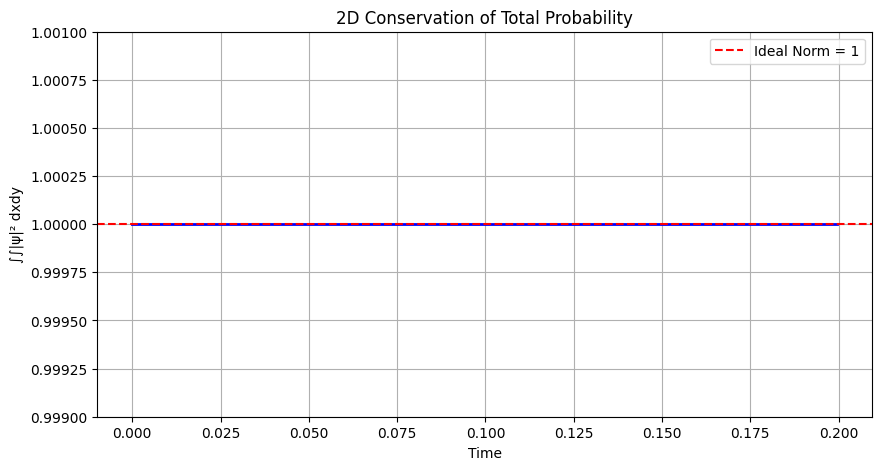

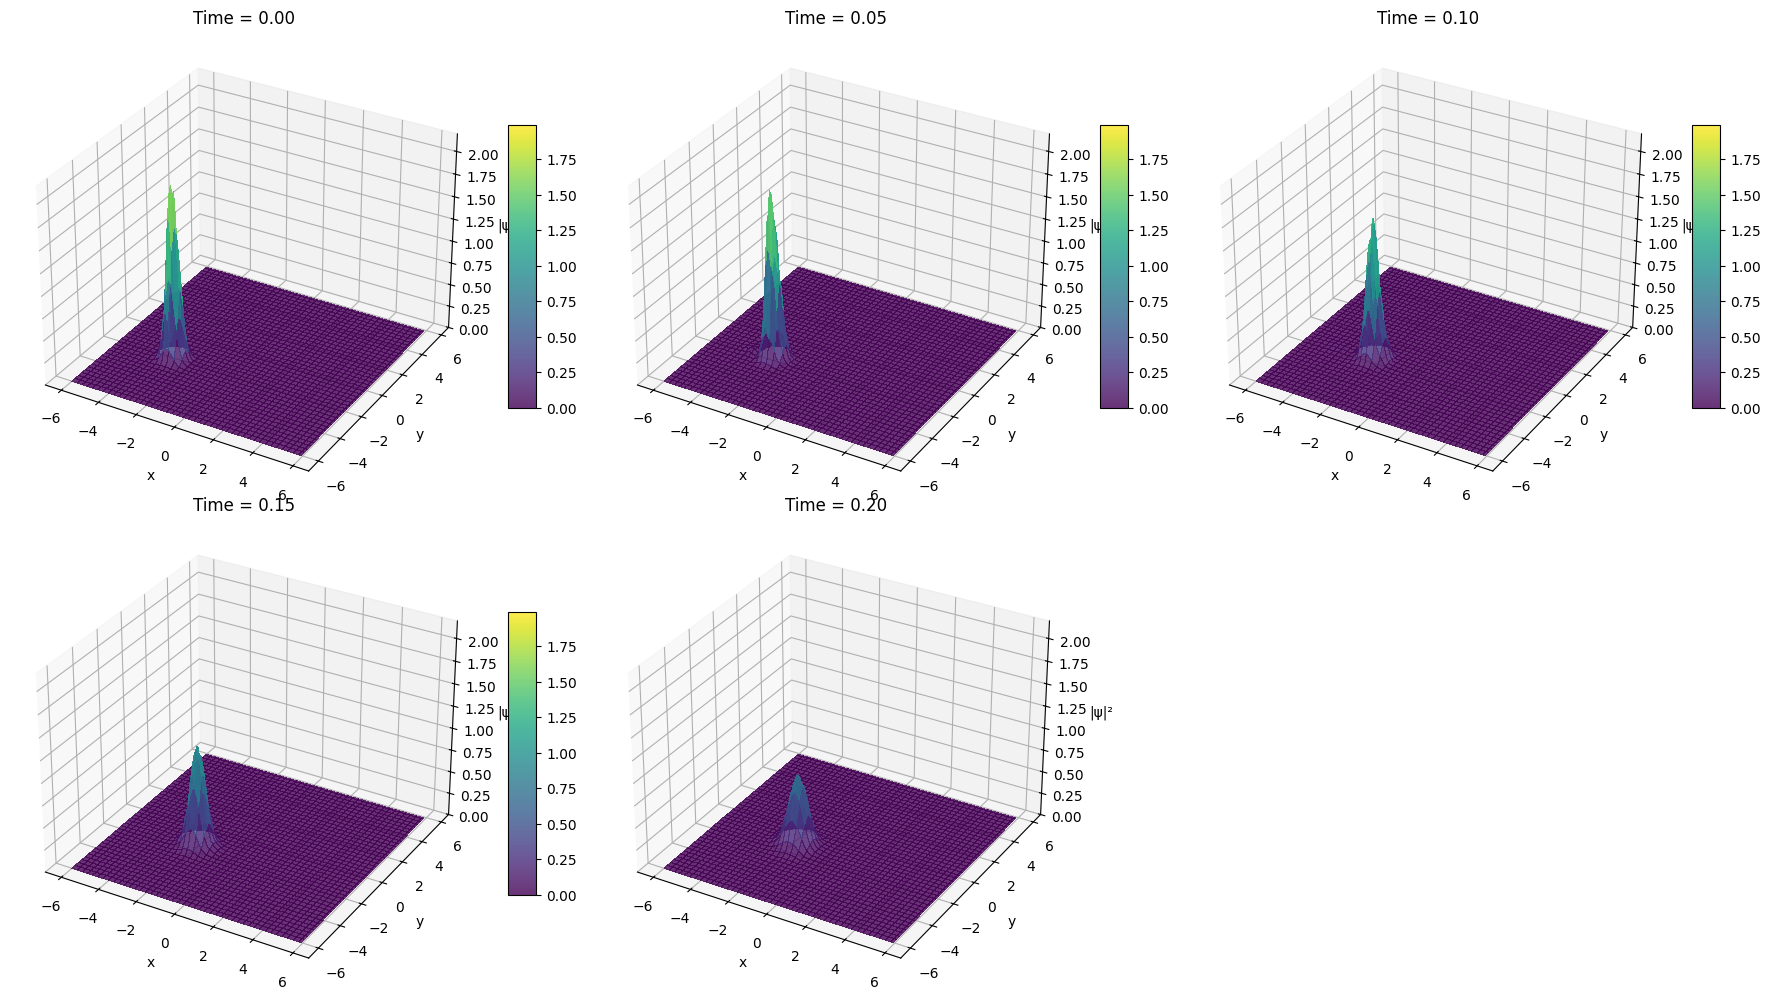

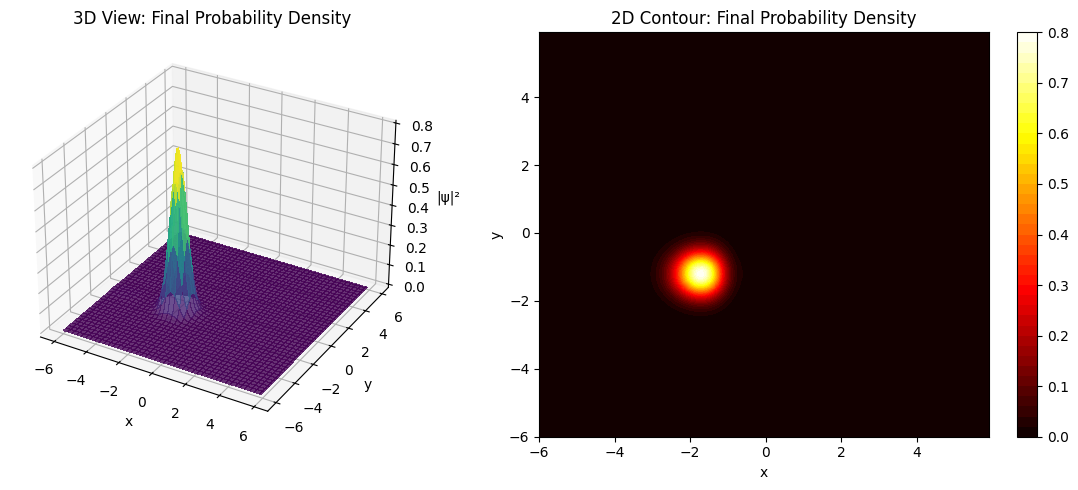

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Create time array for plotting
# Use the actual number of steps from the stored data
actual_num_steps_2D_sim = len(time_evolution_2D)
time_array_2D = np.arange(actual_num_steps_2D_sim) * dt

# 1. Plot conservation of norm
plt.figure(figsize=(10, 5))
plt.plot(time_array_2D, norm_history_2D, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', label='Ideal Norm = 1')
plt.title("2D Conservation of Total Probability")
plt.xlabel("Time")
plt.ylabel("∫∫|ψ|² dxdy")
plt.legend()
plt.grid(True)
plt.ylim(0.999, 1.001)
plt.show()

# 2. Create animation of 2D time evolution
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

all_prob_densities = [np.abs(frame)**2 for frame in time_evolution_2D]
global_max = np.max([np.max(pd) for pd in all_prob_densities])

# Initial probability density
prob_density = np.abs(time_evolution_2D[0])**2
surf = ax.plot_surface(X, Y, prob_density, cmap='viridis',
                       linewidth=0, antialiased=False, alpha=0.8,
                       vmin=0, vmax=global_max)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('|ψ|²')
ax.set_title(f'3D Probability Density Evolution (t = 0.00)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

def animate_3d(frame):
    ax.clear()
    prob_density = np.abs(time_evolution_2D[frame])**2
    surf = ax.plot_surface(X, Y, prob_density, cmap='viridis',
                          linewidth=0, antialiased=False, alpha=0.8,
                          vmin=0, vmax=global_max)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('|ψ|²')
    ax.set_title(f'3D Probability Density (t = {frame*dt:.2f})')
    ax.set_zlim(0, global_max * 1.1)
    return surf,

# Create the animation
anim_3d = FuncAnimation(fig, animate_3d, frames=actual_num_steps_2D_sim, interval=50, blit=False)

# Display the animation
plt.close(fig)
HTML(anim_3d.to_jshtml())

# 3. Static plots at key time steps -3D
key_frames_2d = [0, actual_num_steps_2D_sim//4, actual_num_steps_2D_sim//2, 3*actual_num_steps_2D_sim//4, actual_num_steps_2D_sim-1]
frame_times_2d = [f * dt for f in key_frames_2d]

fig = plt.figure(figsize=(18, 10))

for i, frame in enumerate(key_frames_2d):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    prob_density = np.abs(time_evolution_2D[frame])**2
    surf = ax.plot_surface(X, Y, prob_density, cmap='viridis',
                          linewidth=0, antialiased=False, alpha=0.8,
                          vmin=0, vmax=global_max)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('|ψ|²')
    ax.set_title(f'Time = {frame_times_2d[i]:.2f}')
    ax.set_zlim(0, global_max * 1.1)
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10)

# Remove the last subplot if we have an odd number
if len(key_frames_2d) < 6:
    fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.show()

# 4. 3D surface plot of final probability density
fig = plt.figure(figsize=(12, 5))

# 3D surface plot
ax1 = fig.add_subplot(121, projection='3d')
prob_density_final = np.abs(time_evolution_2D[-1])**2
surf = ax1.plot_surface(X, Y, prob_density_final, cmap='viridis',
                       linewidth=0, antialiased=False, alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('|ψ|²')
ax1.set_title('3D View: Final Probability Density')

# 2D contour plot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, prob_density_final, levels=50, cmap='hot')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('2D Contour: Final Probability Density')
plt.colorbar(contour, ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# Enhanced Visualization: Multiple Animation Types -
# ============================================================================
def create_enhanced_animations_3d(simulation_data, X, Y, V, dt):
    """Create multiple types of 3D animations for a simulation"""
    time_evolution = simulation_data['time_evolution']
    description = simulation_data['description']

    all_prob_densities = [np.abs(frame)**2 for frame in time_evolution]
    global_max = np.max([np.max(pd) for pd in all_prob_densities])
    print(f"Creating 3D animations for: {description}")

    # 1. 3D Probability Density Animation
    fig1 = plt.figure(figsize=(12, 8))
    ax1 = fig1.add_subplot(111, projection='3d')

    prob_density = np.abs(time_evolution[0])**2
    surf1 = ax1.plot_surface(X, Y, prob_density, cmap='viridis',
                           linewidth=0, antialiased=True, alpha=0.8)

    ax1.contour(X, Y, V, zdir='z', offset=0, levels=10, colors='gray', alpha=0.3, linewidths=0.5)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('|ψ|²')
    ax1.set_title(f'{description}\n3D Probability Density')
    ax1.set_zlim(0, global_max)
    fig1.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10)

    def animate_prob_3d(frame):
        ax1.clear()
        prob_density = np.abs(time_evolution[frame])**2
        surf1 = ax1.plot_surface(X, Y, prob_density, cmap='viridis',
                               linewidth=0, antialiased=True, alpha=0.8)
        ax1.contour(X, Y, V, zdir='z', offset=0, levels=10, colors='gray', alpha=0.3, linewidths=0.5)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('|ψ|²')
        ax1.set_title(f'{description}\n3D Probability Density (t = {frame*dt:.2f})')
        ax1.set_zlim(0, global_max)
        return surf1,

    anim1 = FuncAnimation(fig1, animate_prob_3d, frames=len(time_evolution),
                         interval=30, blit=False, repeat=True)
    plt.close(fig1)

    # 2. 3D Phase Animation
    fig2 = plt.figure(figsize=(12, 8))
    ax2 = fig2.add_subplot(111, projection='3d')

    phase = np.angle(time_evolution[0])
    surf2 = ax2.plot_surface(X, Y, phase, cmap='hsv',
                           linewidth=0, antialiased=True, alpha=0.8)
    ax2.contour(X, Y, V, zdir='z', offset=np.min(phase)-0.5, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('Phase')
    ax2.set_title(f'{description}\n3D Phase Distribution')
    fig2.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10)

    def animate_phase_3d(frame):
        ax2.clear()
        phase = np.angle(time_evolution[frame])
        surf2 = ax2.plot_surface(X, Y, phase, cmap='hsv',
                               linewidth=0, antialiased=True, alpha=0.8)
        ax2.contour(X, Y, V, zdir='z', offset=np.min(phase)-0.5, levels=10, colors='black', alpha=0.3, linewidths=0.5)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_zlabel('Phase')
        ax2.set_title(f'{description}\n3D Phase Distribution (t = {frame*dt:.2f})')
        return surf2,

    anim2 = FuncAnimation(fig2, animate_phase_3d, frames=len(time_evolution),
                         interval=30, blit=False, repeat=True)
    plt.close(fig2)

    # 3. 3D Complex Wavefunction Animation
    fig3 = plt.figure(figsize=(14, 10))

    ax3 = fig3.add_subplot(121, projection='3d')
    wave_real = np.real(time_evolution[0])
    surf_real = ax3.plot_surface(X, Y, wave_real, cmap='coolwarm',
                               linewidth=0, antialiased=True, alpha=0.8)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('Re(ψ)')
    ax3.set_title(f'{description}\nReal Part of Wavefunction')
    fig3.colorbar(surf_real, ax=ax3, shrink=0.6, aspect=10)

    ax4 = fig3.add_subplot(122, projection='3d')
    wave_imag = np.imag(time_evolution[0])
    surf_imag = ax4.plot_surface(X, Y, wave_imag, cmap='seismic',
                               linewidth=0, antialiased=True, alpha=0.8)
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.set_zlabel('Im(ψ)')
    ax4.set_title(f'{description}\nImaginary Part of Wavefunction')
    fig3.colorbar(surf_imag, ax=ax4, shrink=0.6, aspect=10)

    plt.tight_layout()

    def animate_complex_3d(frame):
        ax3.clear()
        ax4.clear()

        wave_real = np.real(time_evolution[frame])
        surf_real = ax3.plot_surface(X, Y, wave_real, cmap='coolwarm',
                                   linewidth=0, antialiased=True, alpha=0.8)
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_zlabel('Re(ψ)')
        ax3.set_title(f'{description}\nReal Part (t = {frame*dt:.2f})')

        # 虚部
        wave_imag = np.imag(time_evolution[frame])
        surf_imag = ax4.plot_surface(X, Y, wave_imag, cmap='seismic',
                                   linewidth=0, antialiased=True, alpha=0.8)
        ax4.set_xlabel('x')
        ax4.set_ylabel('y')
        ax4.set_zlabel('Im(ψ)')
        ax4.set_title(f'{description}\nImaginary Part (t = {frame*dt:.2f})')

        return surf_real, surf_imag

    anim3 = FuncAnimation(fig3, animate_complex_3d, frames=len(time_evolution),
                         interval=30, blit=False, repeat=True)
    plt.close(fig3)

    # 4. 3D Probability Flow Animation -
    fig4 = plt.figure(figsize=(12, 8))
    ax5 = fig4.add_subplot(111, projection='3d')

    # (J = Im(ψ* ∇ψ))
    psi = time_evolution[0]
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]

    dpsi_dx, dpsi_dy = np.gradient(psi, dx, dy)
    probability_current_mag = np.abs(np.imag(np.conj(psi) * dpsi_dx) + np.imag(np.conj(psi) * dpsi_dy))

    surf4 = ax5.plot_surface(X, Y, probability_current_mag, cmap='plasma',
                           linewidth=0, antialiased=True, alpha=0.8)
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')
    ax5.set_zlabel('|J|')
    ax5.set_title(f'{description}\nProbability Current Magnitude')
    fig4.colorbar(surf4, ax=ax5, shrink=0.6, aspect=10)

    def animate_current_3d(frame):
        ax5.clear()
        psi = time_evolution[frame]
        dpsi_dx, dpsi_dy = np.gradient(psi, dx, dy)
        probability_current_mag = np.abs(np.imag(np.conj(psi) * dpsi_dx) + np.imag(np.conj(psi) * dpsi_dy))

        surf4 = ax5.plot_surface(X, Y, probability_current_mag, cmap='plasma',
                               linewidth=0, antialiased=True, alpha=0.8)
        ax5.contour(X, Y, V, zdir='z', offset=0, levels=10, colors='gray', alpha=0.3, linewidths=0.5)
        ax5.set_xlabel('x')
        ax5.set_ylabel('y')
        ax5.set_zlabel('|J|')
        ax5.set_title(f'{description}\nProbability Current (t = {frame*dt:.2f})')
        return surf4,

    anim4 = FuncAnimation(fig4, animate_current_3d, frames=min(100, len(time_evolution)),  # 限制帧数以提高性能
                         interval=30, blit=False, repeat=True)
    plt.close(fig4)

    return {
        'probability_3d_animation': anim1,
        'phase_3d_animation': anim2,
        'complex_3d_animation': anim3,
        'current_3d_animation': anim4,
        'description': description
    }


In [ ]:

# Create 3D animations for all simulations
all_3d_animations = []
for sim in simulations:
    anims_3d = create_enhanced_animations_3d(sim, X, Y,
                                           potentials[sim['description'].split(' in ')[1]], dt)
    all_3d_animations.append(anims_3d)



Creating 3D animations for: Moving Gaussian in Infinite Well
Creating 3D animations for: Stationary State in Harmonic Oscillator
Creating 3D animations for: Vortex in Double Well


Creating momentum space visualization for: Moving Gaussian in Infinite Well


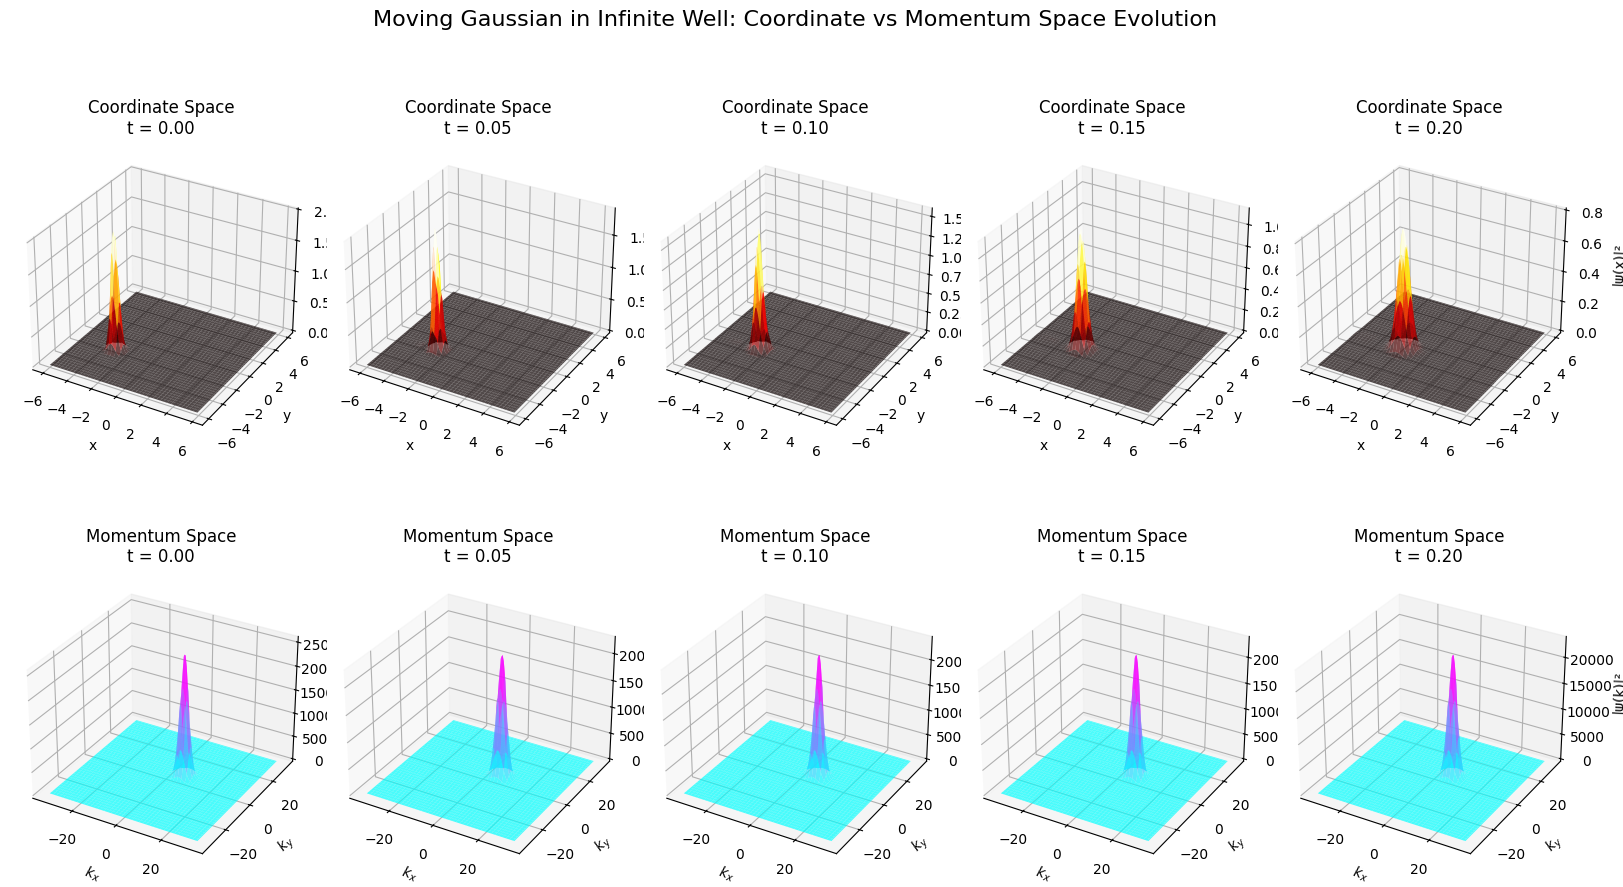

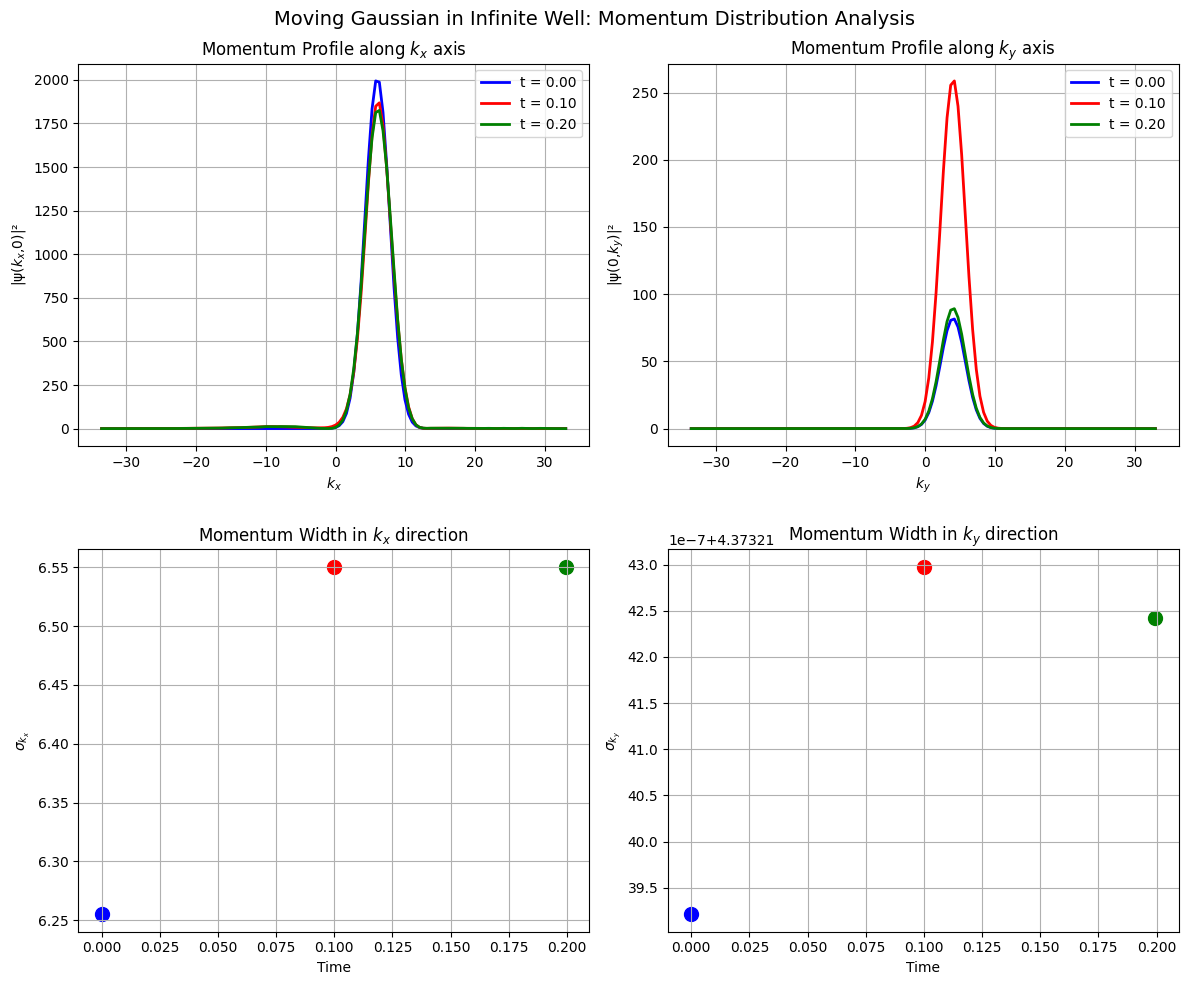

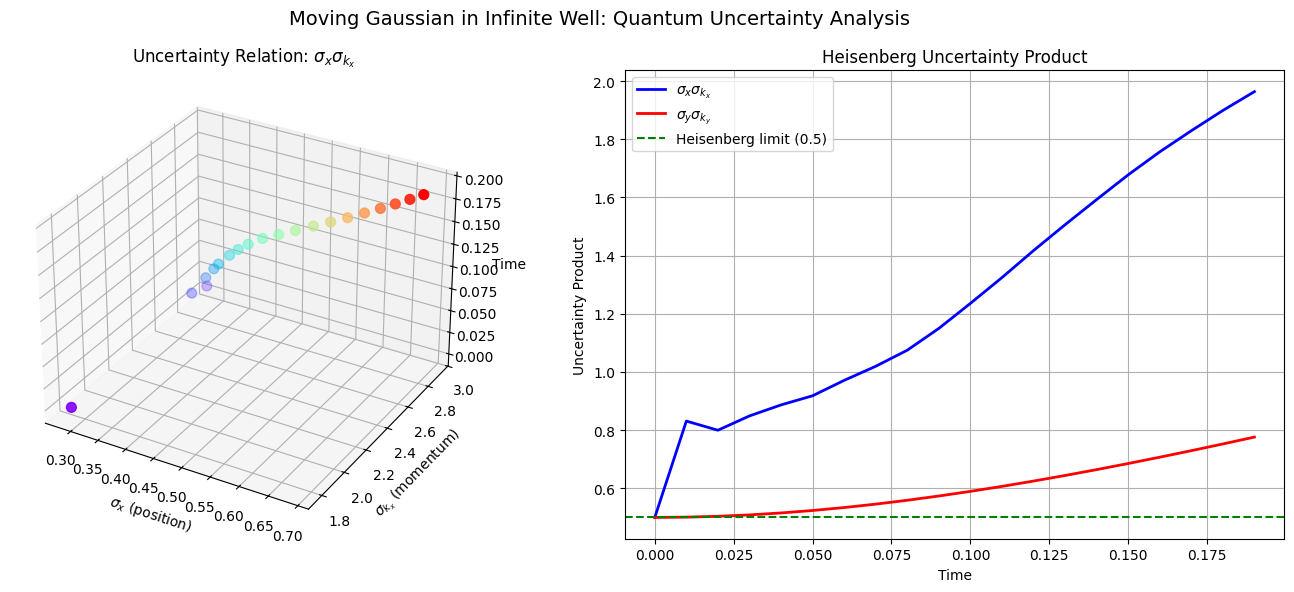

Creating momentum space visualization for: Stationary State in Harmonic Oscillator


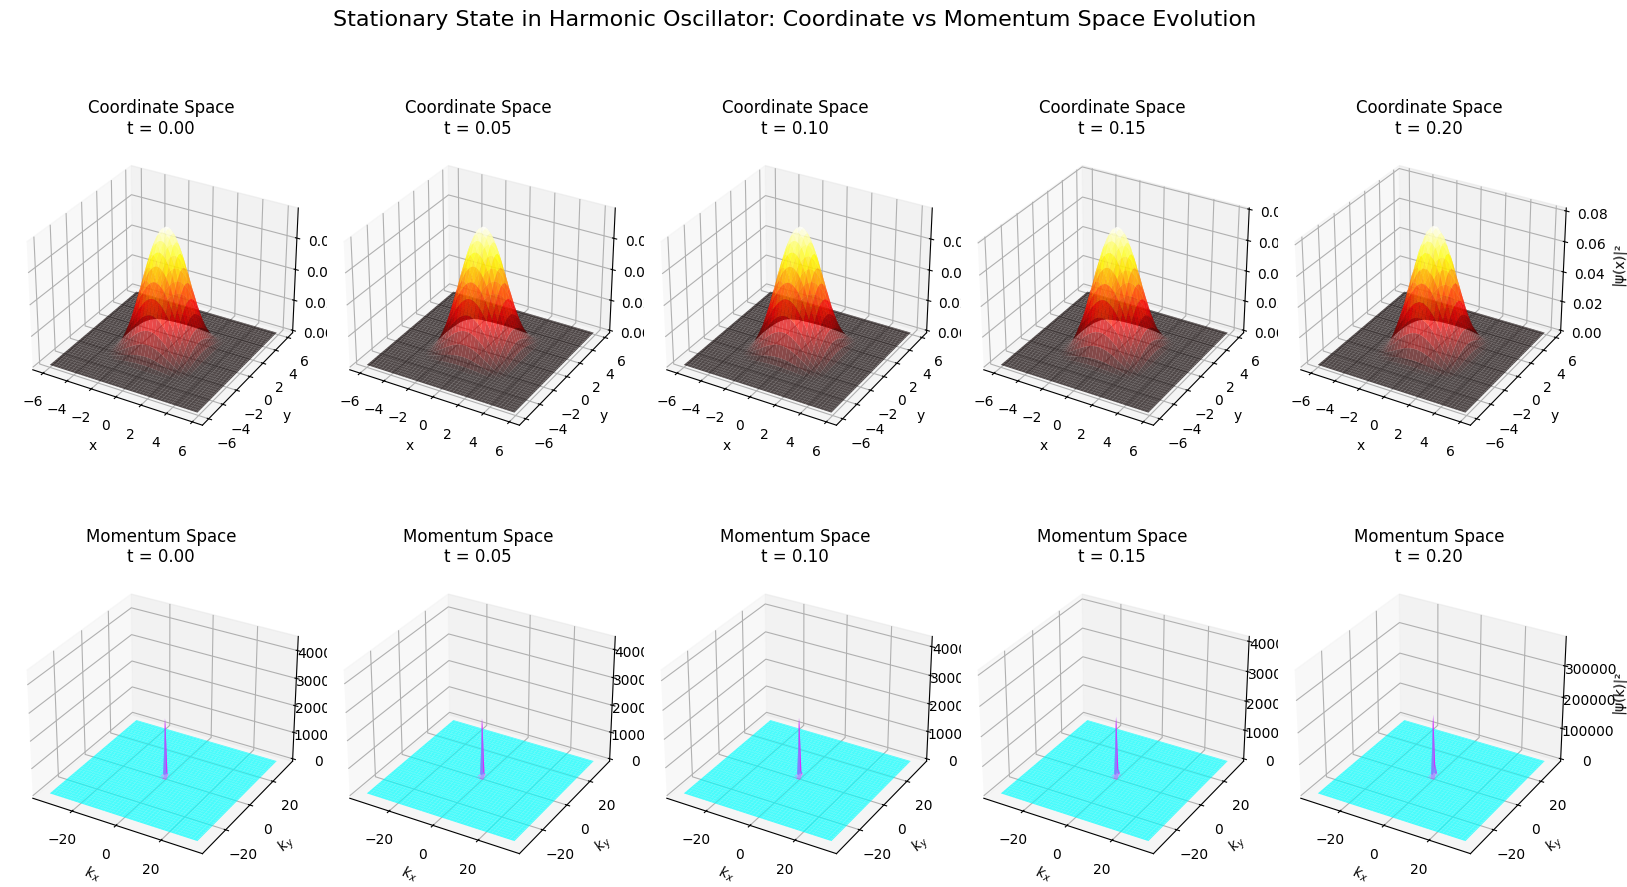

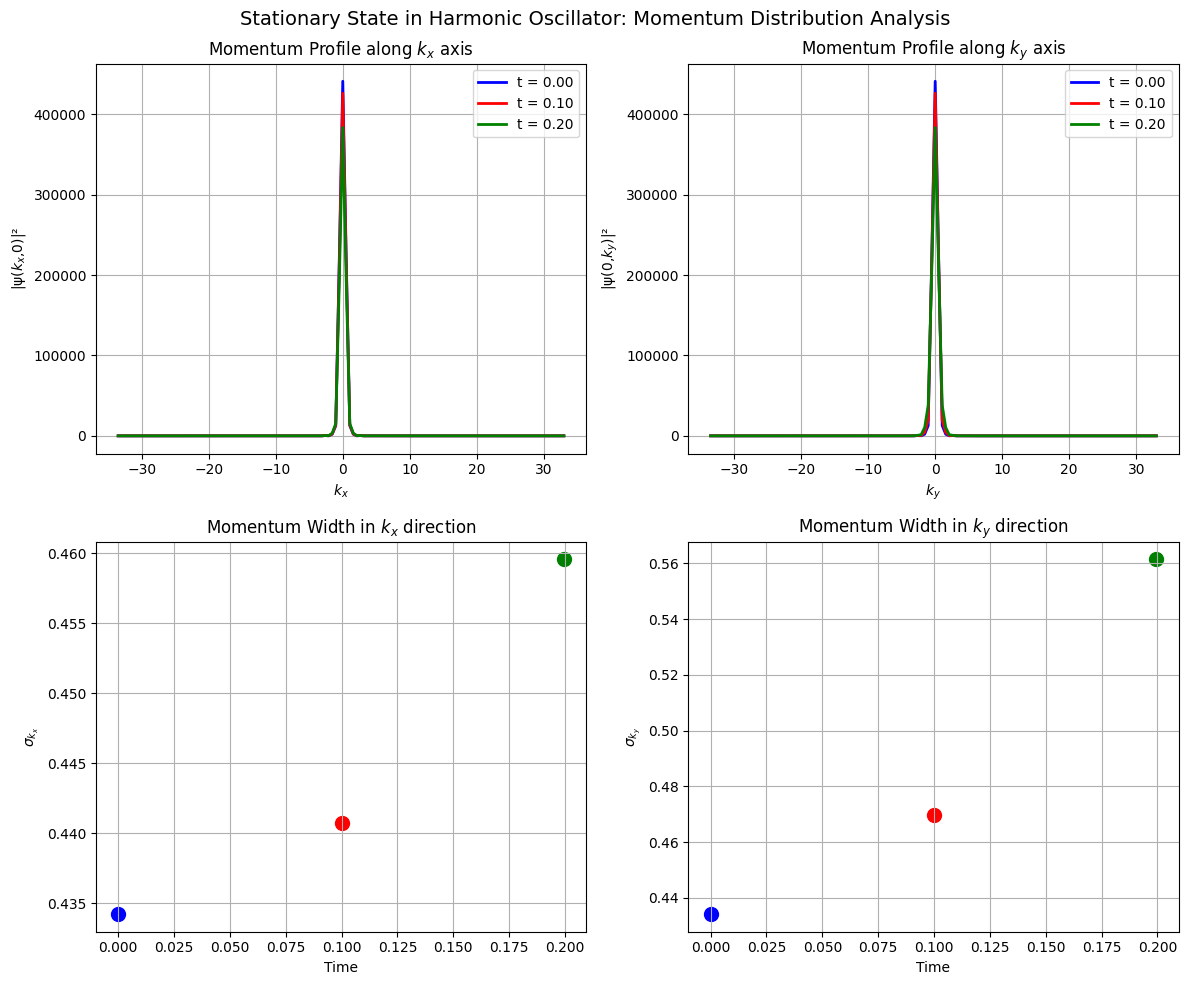

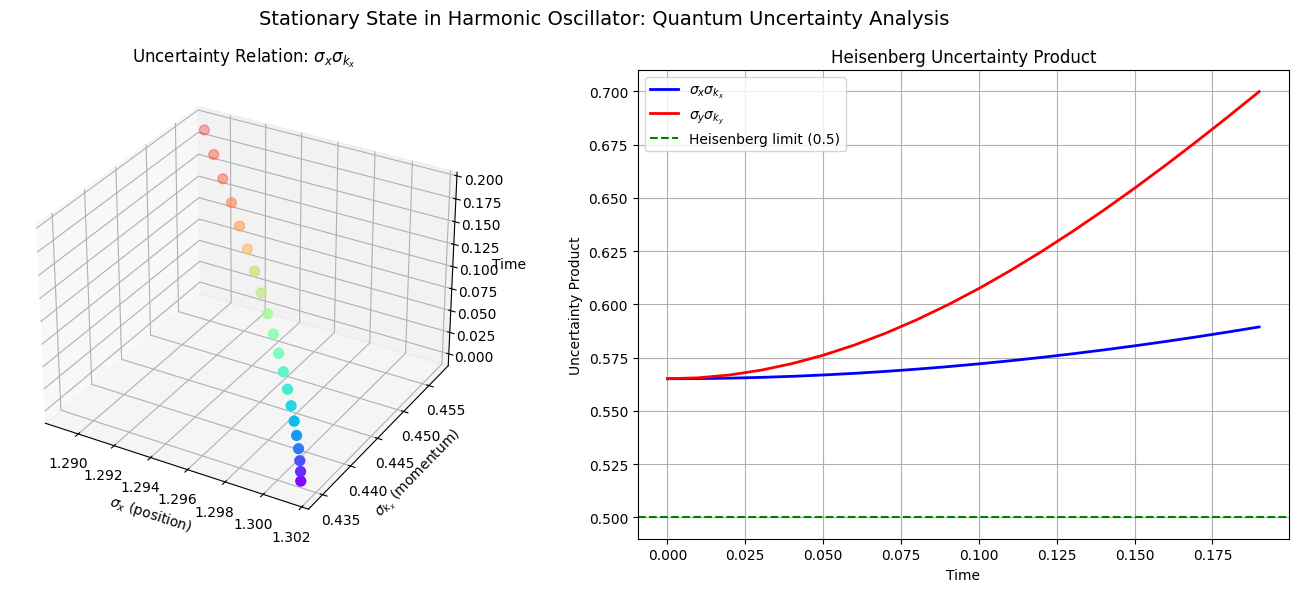

Creating momentum space visualization for: Vortex in Double Well


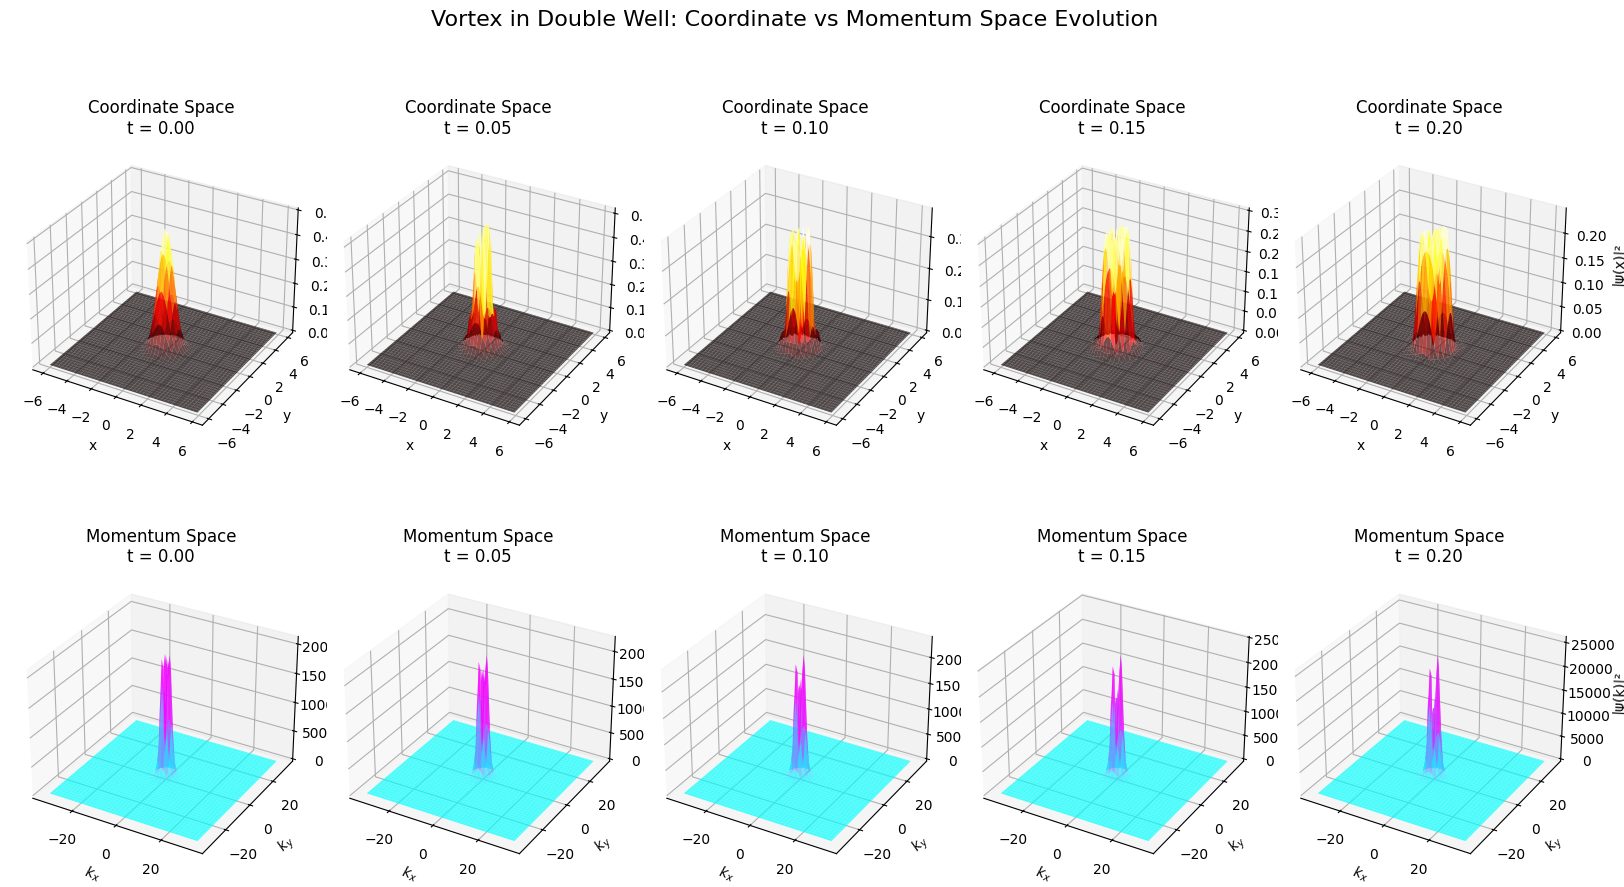

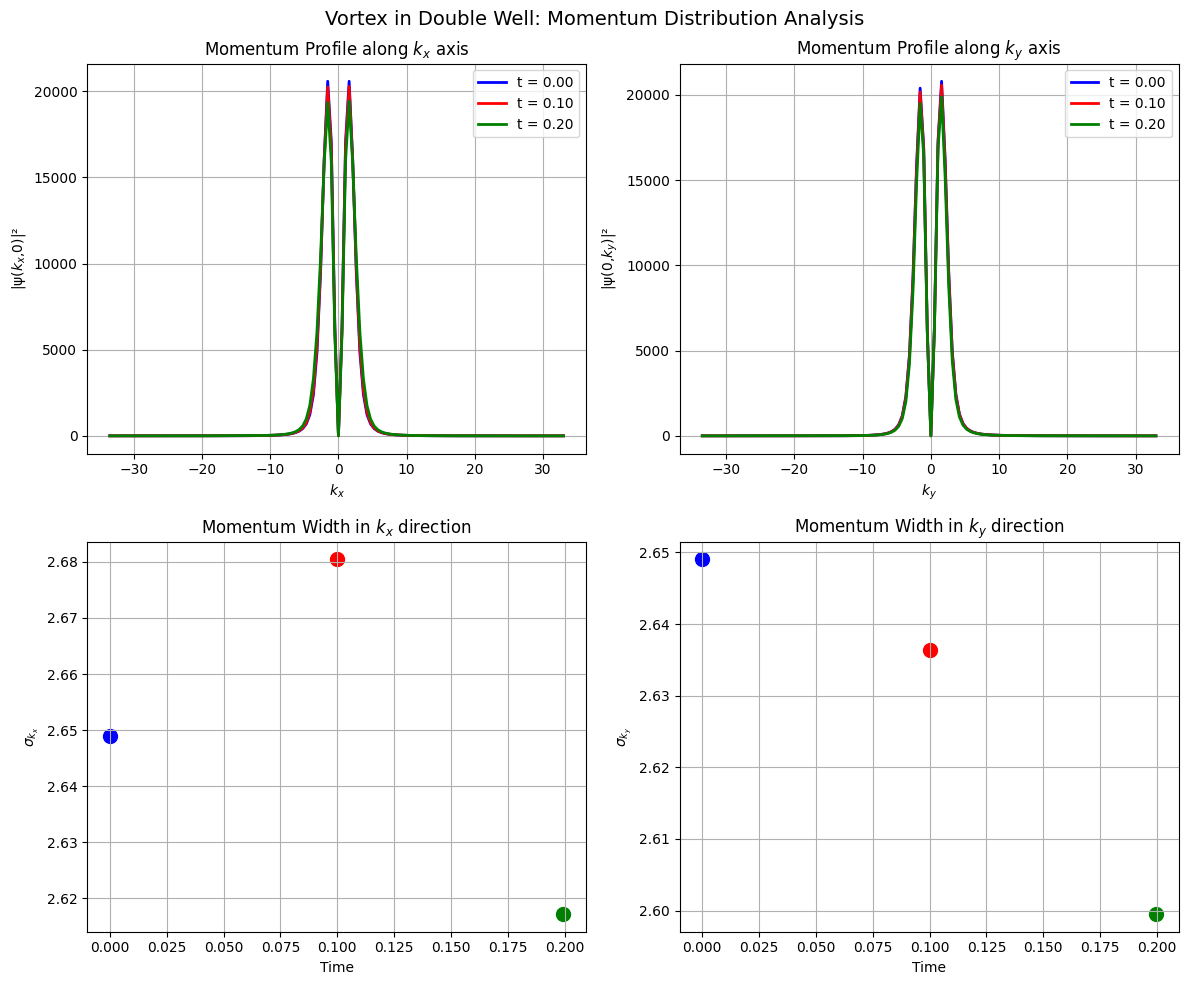

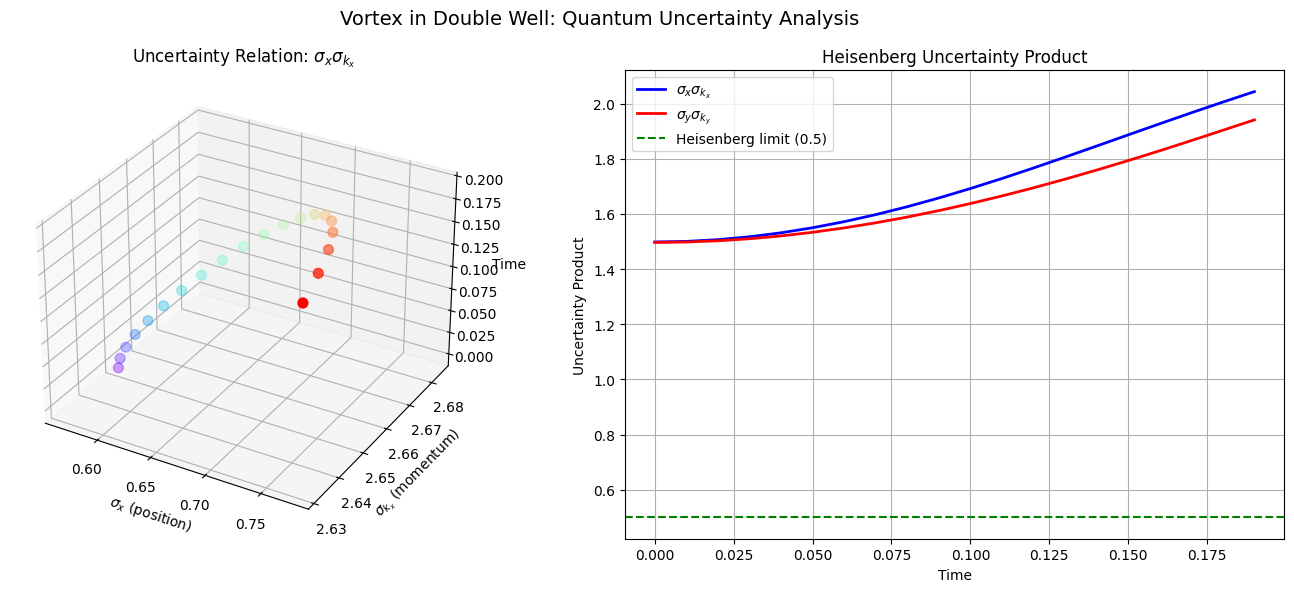

Displaying momentum space visualization for: Moving Gaussian in Infinite Well
1. 3D Momentum Space Animation:


In [ ]:
# ============================================================================
# Momentum Space Visualization: 3D Momentum Distribution
# ============================================================================
def create_momentum_space_visualization(simulation_data, dt):
    """Create 3D momentum space visualization from wavefunction"""
    time_evolution = simulation_data['time_evolution']
    description = simulation_data['description']

    print(f"Creating momentum space visualization for: {description}")

    # --- Re-derive grid parameters based on time_evolution data ---
    Nx_sim, Ny_sim = time_evolution.shape[1], time_evolution.shape[2]

    # We need to use the Lx, Ly from when this simulation data was created
    # Based on notebook structure, this was Lx=12.0, Ly=12.0 in cell '5zohy9UaoXw0'
    original_Lx = 12.0
    original_Ly = 12.0

    x_sim = np.linspace(-original_Lx/2, original_Lx/2, Nx_sim, endpoint=False)
    y_sim = np.linspace(-original_Ly/2, original_Ly/2, Ny_sim, endpoint=False)
    X_sim, Y_sim = np.meshgrid(x_sim, y_sim, indexing='ij')
    dx_sim = x_sim[1] - x_sim[0]
    dy_sim = y_sim[1] - y_sim[0]

    # 计算动量网格 (kx, ky)
    # 动量单位: ℏ = 1 (自然单位制)
    kx_sim = 2 * np.pi * np.fft.fftfreq(Nx_sim, dx_sim)
    ky_sim = 2 * np.pi * np.fft.fftfreq(Ny_sim, dy_sim)
    KX_sim, KY_sim = np.meshgrid(kx_sim, ky_sim, indexing='ij')
    # --- End of re-derivation ---

    # 预计算所有帧的动量空间分布
    momentum_distributions = []
    for psi in time_evolution:
        # 对波函数进行傅里叶变换
        psi_k = np.fft.fftn(psi)
        # 动量空间概率分布 = |ψ(k)|²
        momentum_density = np.abs(psi_k)**2
        # 为了正确显示，需要fftshift
        momentum_density = np.fft.fftshift(momentum_density)
        momentum_distributions.append(momentum_density)

    # 获取全局最大值用于统一z轴范围
    global_max = np.max([np.max(md) for md in momentum_distributions])

    # 1. 3D动量空间动画
    fig1 = plt.figure(figsize=(12, 8))
    ax1 = fig1.add_subplot(111, projection='3d')

    # 对KX, KY进行fftshift以匹配动量密度
    KX_shift = np.fft.fftshift(KX_sim)
    KY_shift = np.fft.fftshift(KY_sim)

    momentum_density = momentum_distributions[0]
    surf1 = ax1.plot_surface(KX_shift, KY_shift, momentum_density,
                           cmap='viridis', linewidth=0,
                           antialiased=True, alpha=0.8, rstride=1, cstride=1)

    ax1.set_xlabel('$k_x$ (momentum)')
    ax1.set_ylabel('$k_y$ (momentum)')
    ax1.set_zlabel('|ψ(k)|²')
    ax1.set_title(f'{description}\n3D Momentum Space Distribution')
    ax1.set_zlim(0, global_max)
    fig1.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10)

    def animate_momentum_3d(frame):
        ax1.clear()
        momentum_density = momentum_distributions[frame]

        # 限制显示范围，只显示中心区域（大多数动量分布集中在低动量区域）
        k_limit = np.max([np.max(np.abs(KX_shift)), np.max(np.abs(KY_shift))]) * 0.3
        # The mask is not used in plot_surface directly, it's for visual range

        surf1 = ax1.plot_surface(KX_shift, KY_shift, momentum_density,
                               cmap='viridis', linewidth=0,
                               antialiased=True, alpha=0.8, rstride=1, cstride=1)

        ax1.set_xlabel('$k_x$ (momentum)')
        ax1.set_ylabel('$k_y$ (momentum)')
        ax1.set_zlabel('|ψ(k)|²')
        ax1.set_title(f'{description}\n3D Momentum Space (t = {frame*dt:.2f})')
        ax1.set_xlim(-k_limit, k_limit)
        ax1.set_ylim(-k_limit, k_limit)
        ax1.set_zlim(0, global_max)
        return surf1,

    anim1 = FuncAnimation(fig1, animate_momentum_3d,
                         frames=len(momentum_distributions),
                         interval=30, blit=False, repeat=True)
    plt.close(fig1)

    # 2. 动量空间和坐标空间对比（静态关键帧）
    key_frames = [0, len(time_evolution)//4, len(time_evolution)//2,
                 3*len(time_evolution)//4, len(time_evolution)-1]

    fig2 = plt.figure(figsize=(16, 10))

    for i, frame in enumerate(key_frames):
        # 坐标空间概率密度
        ax_coord = fig2.add_subplot(2, 5, i+1, projection='3d')
        coord_density = np.abs(time_evolution[frame])**2
        surf_coord = ax_coord.plot_surface(X_sim, Y_sim, coord_density, cmap='hot',
                                          linewidth=0, antialiased=True, alpha=0.7)
        ax_coord.set_title(f'Coordinate Space\nt = {frame*dt:.2f}')
        ax_coord.set_xlabel('x')
        ax_coord.set_ylabel('y')
        ax_coord.set_zlabel('|ψ(x)|²')

        # 动量空间概率密度
        ax_momentum = fig2.add_subplot(2, 5, i+6, projection='3d')
        momentum_density = momentum_distributions[frame]
        surf_momentum = ax_momentum.plot_surface(KX_shift, KY_shift, momentum_density,
                                                cmap='cool', linewidth=0,
                                                antialiased=True, alpha=0.7)
        ax_momentum.set_title(f'Momentum Space\nt = {frame*dt:.2f}')
        ax_momentum.set_xlabel('$k_x$')
        ax_momentum.set_ylabel('$k_y$')
        ax_momentum.set_zlabel('|ψ(k)|²')

    plt.suptitle(f'{description}: Coordinate vs Momentum Space Evolution', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 3. 动量分布剖面（沿kx和ky轴）
    fig3, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 选择几个关键帧显示动量分布剖面
    profile_frames = [0, len(momentum_distributions)//2, len(momentum_distributions)-1]
    colors = ['b', 'r', 'g']

    for i, frame in enumerate(profile_frames):
        momentum_density = momentum_distributions[frame]

        # 沿kx轴的剖面 (ky=0)
        kx_profile = momentum_density[:, Ny_sim//2]
        axes[0, 0].plot(KX_shift[:, Ny_sim//2], kx_profile,
                       color=colors[i], linewidth=2,
                       label=f't = {frame*dt:.2f}')

        # 沿ky轴的剖面 (kx=0)
        ky_profile = momentum_density[Nx_sim//2, :]
        axes[0, 1].plot(KY_shift[Nx_sim//2, :], ky_profile,
                       color=colors[i], linewidth=2,
                       label=f't = {frame*dt:.2f}')

        # 动量分布宽度随时间变化
        kx_sigma = np.sqrt(np.sum(KX_shift**2 * momentum_density) / np.sum(momentum_density)) if np.sum(momentum_density) > 0 else 0
        ky_sigma = np.sqrt(np.sum(KY_shift**2 * momentum_density) / np.sum(momentum_density)) if np.sum(momentum_density) > 0 else 0

        axes[1, 0].scatter(frame*dt, kx_sigma, color=colors[i], s=100)
        axes[1, 1].scatter(frame*dt, ky_sigma, color=colors[i], s=100)

    axes[0, 0].set_xlabel('$k_x$')
    axes[0, 0].set_ylabel('|ψ($k_x$,0)|²')
    axes[0, 0].set_title('Momentum Profile along $k_x$ axis')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].set_xlabel('$k_y$')
    axes[0, 1].set_ylabel('|ψ(0,$k_y$)|²')
    axes[0, 1].set_title('Momentum Profile along $k_y$ axis')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('$σ_{k_x}$')
    axes[1, 0].set_title('Momentum Width in $k_x$ direction')
    axes[1, 0].grid(True)

    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('$σ_{k_y}$')
    axes[1, 1].set_title('Momentum Width in $k_y$ direction')
    axes[1, 1].grid(True)

    plt.suptitle(f'{description}: Momentum Distribution Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 4. 不确定性关系可视化
    fig4 = plt.figure(figsize=(14, 6))

    # 计算位置和动量的不确定性
    position_uncertainties_x = []
    position_uncertainties_y = []
    momentum_uncertainties_x = []
    momentum_uncertainties_y = []
    times = []

    # Ensure at least some points are sampled for uncertainty
    sample_interval = max(1, len(time_evolution) // 20)
    for frame in range(0, len(time_evolution), sample_interval):
        psi = time_evolution[frame]
        times.append(frame * dt)

        # 坐标空间概率密度
        prob_density = np.abs(psi)**2

        # Calculate expectation values
        total_prob = np.sum(prob_density) * dx_sim * dy_sim
        if total_prob == 0: # Avoid division by zero for empty wavefunctions
             x_expect, y_expect = 0, 0
        else:
             x_expect = np.sum(X_sim * prob_density) * dx_sim * dy_sim / total_prob
             y_expect = np.sum(Y_sim * prob_density) * dx_sim * dy_sim / total_prob

        # 计算位置不确定性 (标准差)
        if total_prob == 0:
            sigma_x, sigma_y = 0, 0
        else:
            sigma_x = np.sqrt(np.sum((X_sim - x_expect)**2 * prob_density) * dx_sim * dy_sim / total_prob)
            sigma_y = np.sqrt(np.sum((Y_sim - y_expect)**2 * prob_density) * dx_sim * dy_sim / total_prob)

        position_uncertainties_x.append(sigma_x)
        position_uncertainties_y.append(sigma_y)

        # 动量空间概率密度
        momentum_density = momentum_distributions[frame]
        total_momentum_prob = np.sum(momentum_density)

        # 计算动量期望值
        if total_momentum_prob == 0:
            kx_expect, ky_expect = 0, 0
        else:
            kx_expect = np.sum(KX_shift * momentum_density) / total_momentum_prob
            ky_expect = np.sum(KY_shift * momentum_density) / total_momentum_prob

        # 计算动量不确定性
        if total_momentum_prob == 0:
            sigma_kx, sigma_ky = 0, 0
        else:
            sigma_kx = np.sqrt(np.sum((KX_shift - kx_expect)**2 * momentum_density) / total_momentum_prob)
            sigma_ky = np.sqrt(np.sum((KY_shift - ky_expect)**2 * momentum_density) / total_momentum_prob)

        momentum_uncertainties_x.append(sigma_kx)
        momentum_uncertainties_y.append(sigma_ky)

    # 绘制不确定性关系
    ax_uncertainty = fig4.add_subplot(121, projection='3d')
    if len(times) > 0:
        ax_uncertainty.scatter(position_uncertainties_x,
                             momentum_uncertainties_x,
                             times,
                             c=times, cmap='rainbow', s=50)
        ax_uncertainty.set_xlabel('$σ_x$ (position)')
        ax_uncertainty.set_ylabel('$σ_{k_x}$ (momentum)')
        ax_uncertainty.set_zlabel('Time')
        ax_uncertainty.set_title('Uncertainty Relation: $σ_xσ_{k_x}$')
    else:
        ax_uncertainty.set_title('No uncertainty data to plot')

    # 绘制不确定性乘积
    ax_product = fig4.add_subplot(122)
    if len(times) > 0:
        uncertainty_product_x = [px * kx for px, kx in zip(position_uncertainties_x, momentum_uncertainties_x)]
        uncertainty_product_y = [py * ky for py, ky in zip(position_uncertainties_y, momentum_uncertainties_y)]

        ax_product.plot(times, uncertainty_product_x, 'b-', linewidth=2, label='$σ_xσ_{k_x}$')
        ax_product.plot(times, uncertainty_product_y, 'r-', linewidth=2, label='$σ_yσ_{k_y}$')
        ax_product.axhline(y=0.5, color='g', linestyle='--', label='Heisenberg limit (0.5)')

        ax_product.set_xlabel('Time')
        ax_product.set_ylabel('Uncertainty Product')
        ax_product.set_title('Heisenberg Uncertainty Product')
        ax_product.legend()
        ax_product.grid(True)
    else:
        ax_product.set_title('No uncertainty data to plot')

    plt.suptitle(f'{description}: Quantum Uncertainty Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()

    return {
        'momentum_3d_animation': anim1,
        'momentum_distributions': momentum_distributions,
        'KX': KX_shift,
        'KY': KY_shift,
        'description': description
    }

# 创建所有模拟的动量空间可视化
all_momentum_visualizations = []
for sim in simulations:
    # Updated call: remove X, Y arguments as they are now derived internally
    momentum_viz = create_momentum_space_visualization(sim, dt)
    all_momentum_visualizations.append(momentum_viz)

# 显示一个模拟的动量空间可视化
display_index = 0  # 可以更改这个索引来查看不同的模拟

print(f"Displaying momentum space visualization for: {all_momentum_visualizations[display_index]['description']}")
print("=" * 60)

# 显示3D动量空间动画
print("1. 3D Momentum Space Animation:")
HTML(all_momentum_visualizations[display_index]['momentum_3d_animation'].to_jshtml())

In [ ]:
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    def create_interactive_3d_visualization(simulation_data, X, Y, V, dt):
        """Create interactive 3D visualization using Plotly"""
        time_evolution = simulation_data['time_evolution']
        description = simulation_data['description']

        print(f"Creating interactive 3D visualization for: {description}")

        key_frames = [0, len(time_evolution)//4, len(time_evolution)//2,
                    3*len(time_evolution)//4, len(time_evolution)-1]

        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=[f'Time = {f*dt:.2f}' for f in key_frames],
            specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}],
                  [{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]]
        )

        for i, frame in enumerate(key_frames):
            prob_density = np.abs(time_evolution[frame])**2

            row = i // 3 + 1
            col = i % 3 + 1

            fig.add_trace(
                go.Surface(
                    x=X, y=Y, z=prob_density,
                    colorscale='Viridis',
                    showscale=True,
                    opacity=0.8,
                    contours=dict(z=dict(show=True, size=0.05))
                ),
                row=row, col=col
            )

        fig.update_layout(
            title=f"{description} - 3D Probability Density",
            height=800,
            scene=dict(
                xaxis_title='x',
                yaxis_title='y',
                zaxis_title='|ψ|²'
            )
        )

        fig.show()

        return fig
    for sim in simulations[:1]:
        interactive_fig = create_interactive_3d_visualization(
            sim, X, Y, potentials[sim['description'].split(' in ')[1]], dt
        )

except ImportError:
    print("Plotly not available. Using matplotlib only.")